In [167]:
# Load required modules
%matplotlib inline
import math, os, cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from PIL import Image
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from yolov5.train import run as run_train
from yolov5.detect import run as run_detect
from  matplotlib import pyplot as plt
import pandas as pd

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saosokleng (use `wandb login --relogin` to force relogin)


In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of devices: 2


In [3]:
# Global function declaration
# convert image to grayscale
def to_one_channel(image):
    return image[:,:,0] if len(image.shape)>2 else image

# resize the image
def resize_image(image, new_shape):
    image = image.resize((new_shape),Image.ANTIALIAS)
    return image

# split dataset into train and test
def split_train_test(tooth, masks, train_percentage):
    divide_index = math.ceil(len(tooth)*train_percentage/100)
    X_train=tooth[:divide_index,:,:,:]
    X_test=tooth[divide_index:,:,:,:]
    y_train=masks[:divide_index,:,:,:]
    y_test=masks[divide_index:,:,:,:]
    return (X_train, y_train),(X_test, y_test)

# loading dataset function
def load_dataset(dataset_folder, rgb = False, normalize = True):
    images = []
    pbl_file_list = os.listdir('./dataset/pbl-mask')
    for teeth in natsorted(os.listdir(dataset_folder)):
        if f'{teeth.split(".")[0]}_PBL_lable.png' in pbl_file_list or f'{teeth.split("_")[0]}_PBL_lable.png' in pbl_file_list:
            image = Image.open(os.path.join(dataset_folder, teeth))
            image = resize_image(image, (2752, 1372))
            width, height = image.size
            # image = image.crop((300, 300, width-300, height))
            image = resize_image(image, (512, 512))
            image = np.asarray(image) if rgb else to_one_channel(np.asarray(image))
            images.append(image)
    if not rgb:
        images = np.asarray(images) / 255.0 if normalize else np.asarray(images)
        images = np.reshape(images, (len(images),images.shape[1], images.shape[2], 1))
    return images

# plot unet loss value
def unet_lost_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
    plt.savefig('./result/unet/unet_perfomance.png', facecolor='white', dpi=1000)
    plt.show()

In [4]:
# Unet model for PBl boundary detection
class pbl_detection_model:
    def __init__(self, input_shape=(512,512,1)):
        self.input_shape = input_shape
    def model(self):
        # define input layer for UNET
        inputs=Input(shape= self.input_shape)
        
        conv1 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        d1=Dropout(0.1)(conv1)
        conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
        b=BatchNormalization()(conv2)
        
        pool1 = MaxPooling2D(pool_size=(2, 2))(b)
        conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        d2=Dropout(0.2)(conv3)
        conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
        b1=BatchNormalization()(conv4)
        
        pool2 = MaxPooling2D(pool_size=(2, 2))(b1)
        conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        d3=Dropout(0.3)(conv5)
        conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
        b2=BatchNormalization()(conv6)
        
        pool3 = MaxPooling2D(pool_size=(2, 2))(b2)
        conv7 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        d4=Dropout(0.4)(conv7)
        conv8 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
        b3=BatchNormalization()(conv8)
        
        pool4 = MaxPooling2D(pool_size=(2, 2))(b3)
        conv9 = Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        d5=Dropout(0.5)(conv9)
        conv10 = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
        b4=BatchNormalization()(conv10)
        
        
        conv11 = Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
        x= concatenate([conv11,conv8])
        conv12 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
        d6=Dropout(0.4)(conv12)
        conv13 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
        b5=BatchNormalization()(conv13)
        
        
        conv14 = Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
        x1=concatenate([conv14,conv6])
        conv15 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
        d7=Dropout(0.3)(conv15)
        conv16 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
        b6=BatchNormalization()(conv16)
        
        conv17 = Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
        x2=concatenate([conv17,conv4])
        conv18 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
        d8=Dropout(0.2)(conv18)
        conv19 = Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
        b7=BatchNormalization()(conv19)
        
        conv20 = Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
        x3=concatenate([conv20,conv2])
        conv21 = Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
        d9=Dropout(0.1)(conv21)
        conv22 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)
        
        outputs = Conv2D(1,(1,1), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv22)
        
        return Model( inputs = inputs, outputs = outputs)

In [4]:
# Unet model for PBl boundary detection
class cej_detection_model:
    def __init__(self, input_shape=(512,512,1)):
        self.input_shape = input_shape
    def model(self):
        # define input layer for UNET
        inputs=Input(shape= self.input_shape)
        
        conv1 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        d1=Dropout(0.1)(conv1)
        conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
        b=BatchNormalization()(conv2)
        
        pool1 = MaxPooling2D(pool_size=(2, 2))(b)
        conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        d2=Dropout(0.2)(conv3)
        conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
        b1=BatchNormalization()(conv4)
        
        pool2 = MaxPooling2D(pool_size=(2, 2))(b1)
        conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        d3=Dropout(0.3)(conv5)
        conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
        b2=BatchNormalization()(conv6)
        
        pool3 = MaxPooling2D(pool_size=(2, 2))(b2)
        conv7 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        d4=Dropout(0.4)(conv7)
        conv8 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
        b3=BatchNormalization()(conv8)
        
        pool4 = MaxPooling2D(pool_size=(2, 2))(b3)
        conv9 = Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        d5=Dropout(0.5)(conv9)
        conv10 = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
        b4=BatchNormalization()(conv10)
        
        
        conv11 = Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
        x= concatenate([conv11,conv8])
        conv12 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
        d6=Dropout(0.4)(conv12)
        conv13 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
        b5=BatchNormalization()(conv13)
        
        
        conv14 = Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
        x1=concatenate([conv14,conv6])
        conv15 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
        d7=Dropout(0.3)(conv15)
        conv16 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
        b6=BatchNormalization()(conv16)
        
        conv17 = Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
        x2=concatenate([conv17,conv4])
        conv18 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
        d8=Dropout(0.2)(conv18)
        conv19 = Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
        b7=BatchNormalization()(conv19)
        
        conv20 = Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
        x3=concatenate([conv20,conv2])
        conv21 = Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
        d9=Dropout(0.1)(conv21)
        conv22 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)
        
        outputs = Conv2D(1,(1,1), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv22)
        
        return Model( inputs = inputs, outputs = outputs)

In [5]:
# global variables
TEETH_DATASET, TEETH_PBL, TEETH_CEJ, TEETH_NUMBER = './dataset/original-data', './dataset/pbl-mask', './dataset/cej-mask', './dataset/teeth-color'
PBL_EPOCH, PBL_BATCH = 100 , 16
CEJ_EPOCH, CEJ_BATCH = 20 , 16
ORIGINAL_IMG_SIZE = (2752, 1372)

In [6]:
# print('==> Please wait. Loading dataset...')
# # load dataset
# original_dataset = load_dataset(TEETH_DATASET)
# pbl_dataset = load_dataset(TEETH_PBL)

# # split dataset 80% train
# (pbl_X_train, pbl_y_train), (pbl_X_test, pbl_y_test) = split_train_test(original_dataset, pbl_dataset, 80)
# print('==> Finish loading dataset.')

==> Please wait. Loading dataset...
==> Finish loading dataset.


In [6]:
print('==> Please wait. Loading dataset...')
# load dataset
original_dataset = load_dataset(TEETH_DATASET)
# pbl_dataset = load_dataset(TEETH_PBL)
cej_dataset = load_dataset(TEETH_CEJ)

# split dataset 80% train
(cej_X_train, cej_y_train), (cej_X_test, cej_y_test) = split_train_test(original_dataset, cej_dataset, 80)
print('==> Finish loading dataset.')

==> Please wait. Loading dataset...
==> Finish loading dataset.


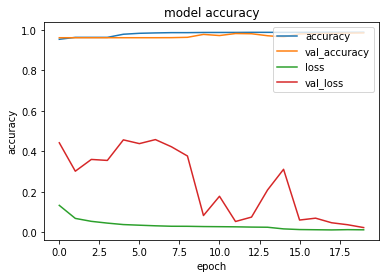

In [19]:
unet_lost_history(history)

In [13]:
# Open a strategy scope.
with strategy.scope():
    # Start fitting pbl model
    print('==> Start training UNET...')
    cej_model = cej_detection_model(input_shape = (512, 512, 1)).model()
    cej_model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = cej_model.fit(cej_X_train,cej_y_train, validation_split = 0.2, batch_size=CEJ_BATCH, epochs=CEJ_EPOCH, verbose=1)
pbl_model.save('./result/unet/unet_model_cej.h5')
pbl_model.summary()
unet_lost_history(history)
print('Finish UNET training...')

==> Start training UNET...
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


42/42 [==============================] - 38s 550ms/step - loss: 0.1334 - accuracy: 0.9537 - val_loss: 0.4425 - val_accuracy: 0.9614
Epoch 2/20
42/42 [==============================] - 15s 358ms/step - loss: 0.0691 - accuracy: 0.9631 - val_loss: 0.3022 - val_accuracy: 0.9614
Epoch 3/20
42/42 [==============================] - 15s 357ms/step - loss: 0.0546 - accuracy: 0.9631 - val_loss: 0.3603 - val_accuracy: 0.9614
Epoch 4/20
42/42 [==============================] - 15s 358ms/step - loss: 0.0459 - accuracy: 0.9631 - val_loss: 0.3554 - val_accuracy: 0.9614
Epoch 5/20
42/42 [==============================] - 15s 362ms/step - loss: 0.0386 - accuracy: 0.9786 - val_loss: 0.4570 - val_accuracy: 0.9614
Epoch 6/20
42/42 [==============================] - 15s 356ms/step - loss: 0.0355 - accuracy: 0.9833 - val_loss: 0.4384 - val_accuracy: 0.9614
Epoch 7/20
42/42 [==============================] - 15s 366ms/step - loss: 0.0325 - accuracy: 0.9851 - val_loss: 0.4583 - val_accuracy: 0.9614
Epoch 8/20

NameError: name 'pbl_model' is not defined

In [20]:
# ce_model = tf.keras.models.load_model('./result/unet/unet_model.h5')
predictions = cej_model.predict(cej_X_test)

Instructions for updating:
use `experimental_local_results` instead.


From /home/ubuntu/.local/lib/python3.9/site-packages/keras/engine/training.py:2975: StrategyBase.unwrap (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
use `experimental_local_results` instead.


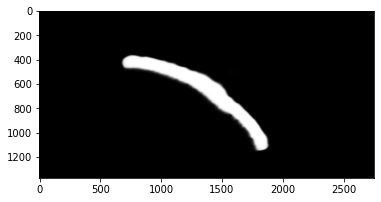

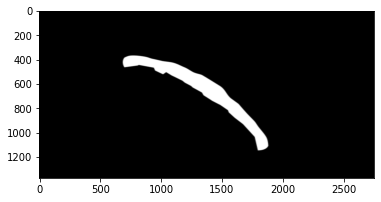

In [33]:
index = 70
d = cv2.resize(predictions[index], dsize=ORIGINAL_IMG_SIZE)
plt.imshow(d, cmap='gray')
plt.show()
c = cv2.resize(cej_y_test[index], dsize=ORIGINAL_IMG_SIZE)
plt.imshow(c, cmap='gray')

In [7]:
# # Open a strategy scope.
# with strategy.scope():
#     # Start fitting pbl model
#     print('==> Start training UNET...')
#     pbl_model = pbl_detection_model(input_shape = (512, 512, 1)).model()
#     pbl_model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# history = pbl_model.fit(pbl_X_train,pbl_y_train, validation_split = 0.2, batch_size=PBL_BATCH, epochs=PBL_EPOCH, verbose=1)
# pbl_model.save('./result/unet/unet_model.h5')
# pbl_model.summary()
# unet_lost_history(history)
# print('Finish UNET training...')

==> Start training UNET...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1


42/42 [==============================] - 39s 560ms/step - loss: 0.2322 - accuracy: 0.8945 - val_loss: 0.8222 - val_accuracy: 0.8882
Epoch 2/100
42/42 [==============================] - 15s 358ms/step - loss: 0.0963 - accuracy: 0.9569 - val_loss: 0.9316 - val_accuracy: 0.7340
Epoch 3/100
42/42 [==============================] - 15s 360ms/step - loss: 0.0682 - accuracy: 0.9673 - val_loss: 1.1784 - val_accuracy: 0.8882
Epoch 4/100
42/42 [==============================] - 15s 361ms/step - loss: 0.0538 - accuracy: 0.9725 - val_loss: 0.7770 - val_accuracy: 0.6152
Epoch 5/100
42/42 [==============================] - 15s 358ms/step - loss: 0.0461 - accuracy: 0.9747 - val_loss: 0.4138 - val_accuracy: 0.8701
Epoch 6/100
42/42 [==============================] - 15s 363ms/step - loss: 0.0395 - accuracy: 0.9772 - val_loss: 0.6999 - val_accuracy: 0.8877
Epoch 7/100
42/42 [==============================] - 15s 360ms/step - loss: 0.0361 - accuracy: 0.9783 - val_loss: 0.3302 - val_accuracy: 0.8485
Epoc

In [55]:
a = history.history

In [59]:
a = history.history
a['accuracy'] = a['accuracy'][:98]
a['val_accuracy'] = a['val_accuracy'][:98]
a['loss'] = a['loss'][:98]
a['val_loss'] = a['val_loss'][:98]
b = {}
b['history'] = a

In [60]:
# a['val_loss']

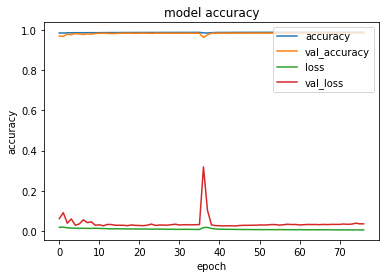

In [61]:
plt.plot(b['history']['accuracy'])
plt.plot(b['history']['val_accuracy'])
plt.plot(b['history']['loss'])
plt.plot(b['history']['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
plt.savefig('./result/unet/unet_perfomance.png', facecolor='white', dpi=1000)
plt.show()

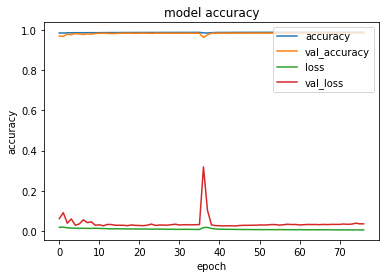

In [62]:
unet_lost_history(history)

In [8]:
pbl_model = tf.keras.models.load_model('./result/unet/unet_model.h5')
predictions = pbl_model.predict(pbl_X_test)

In [9]:
predictions[1].shape

(512, 512, 1)

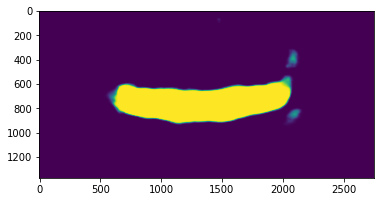

In [72]:
d = cv2.resize(predictions[17], dsize=ORIGINAL_IMG_SIZE)
plt.imshow(d)
# plt.show()

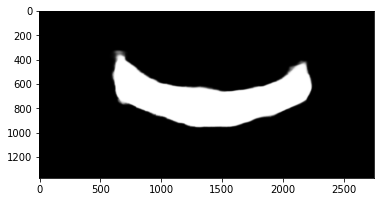

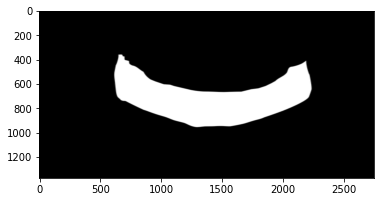

In [112]:
index = 64
d = cv2.resize(predictions[index], dsize=ORIGINAL_IMG_SIZE)
plt.imshow(d, cmap='gray')
plt.show()
c = cv2.resize(pbl_y_test[index], dsize=ORIGINAL_IMG_SIZE)
plt.imshow(c, cmap='gray')

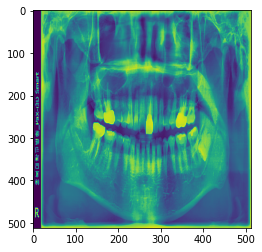

In [63]:
plt.imshow(pbl_X_test[16])

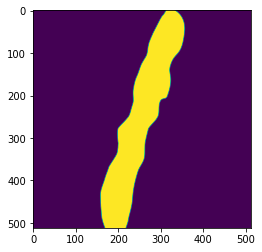

In [33]:
plt.imshow(pbl_y_test[0])

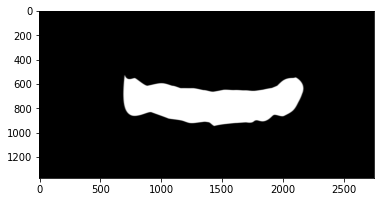

In [109]:
prediction = cv2.resize(pbl_y_test[1], dsize=ORIGINAL_IMG_SIZE)
plt.imshow(prediction, cmap='gray')
plt.show()

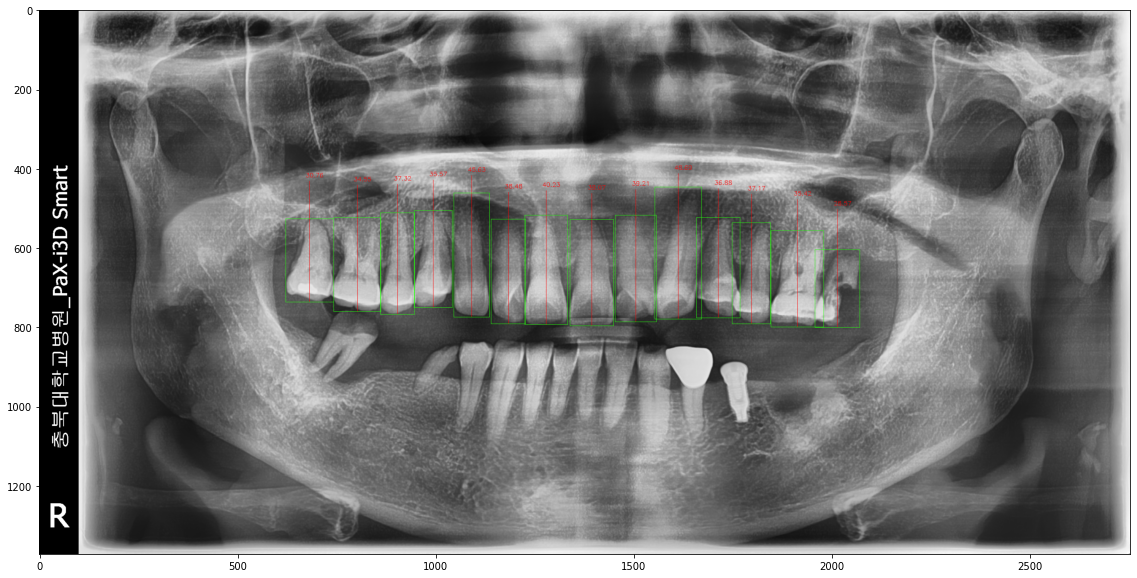

In [99]:
img = cv2.imread('./dataset/yolov5-dataset/images/train/1.png')
pbl_mask = cv2.imread('./dataset/pbl-mask/1_PBL_lable.png')
with open('./dataset/yolov5-dataset/labels/train/1.txt') as f:
    for line in f.readlines():
        xywh = [float(x) for x in line.replace('\n','').split(' ')[1:5]]

        img_height, img_width, _ = img.shape
        xc = float(xywh[0]) * img_width
        yc = float(xywh[1]) * img_height
        box_width = float(xywh[2]) * img_width
        box_height = float(xywh[3]) * img_height
        coordinates = np.array( [[xc,yc-200], [xc,yc+(box_height/2)]], dtype=np.int32 )
        cv2.polylines(img, [coordinates], True, 255, 1)
        cv2.rectangle(img, (int(xc-(box_width/2)), int(yc-(box_height/2))), (int(xc+(box_width/2)), int(yc+(box_height/2))), (36,255,12), 1)
        text_location = (int(xc-10),int(yc-210))
        box_height_mm = (box_height * 200) / img_height
        cv2.putText(img, f'{round(box_height_mm, 2)}', text_location, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)
fig = plt.figure()
fig.set_size_inches(50,10)
plt.imshow(img)


In [100]:
pbl_mask.shape

(1372, 2752, 3)

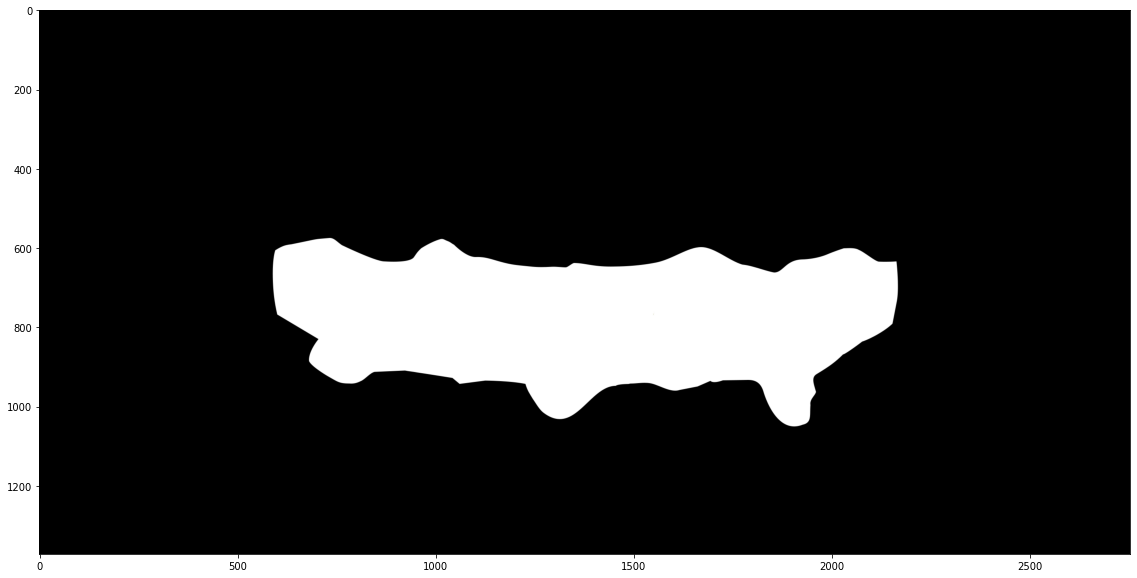

In [ ]:
plt.imshow(pbl_mask)

run_train(data='custom-coco.yaml', imgsz=640, weights='./yolov5/yolov5s.pt', batch=16, epochs = 50, project='./result/yolo')

In [1]:
%matplotlib inline
import math, os, cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from PIL import Image
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from yolov5.train import run as run_train
from yolov5.detect import run as run_detect
from  matplotlib import pyplot as plt

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saosokleng (use `wandb login --relogin` to force relogin)


In [50]:
WEIGHT_DIR = './result/yolo/exp4/weights/best.pt'
SOURCE = './dataset/yolov5-dataset/images/train/1.png'
IMAGE_SIZE = [640, 640]

In [1]:
detect_result = run_detect(weights=WEIGHT_DIR, imgsz=IMAGE_SIZE, conf_thres=0.1, source=SOURCE, project='./result/yolo/detect',line_thickness = 1, save_crop=True, save_txt=True)

YOLOv5 🚀 634d604 torch 1.7.1+cu110 CUDA:0 (Tesla V100S-PCIE-32GB, 32511MiB)

Fusing layers... 
Model Summary: 213 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
image 1/1 /home/ubuntu/jupyter-lab/reach/dental-segmentation/dataset/yolov5-dataset/images/train/2.png: 320x640 1 teeth_11, 5 teeth_12s, 1 teeth_14, 1 teeth_16, 3 teeth_17s, 1 teeth_22, 1 teeth_24, 4 teeth_26s, 2 teeth_27s, Done. (0.014s)
Speed: 0.4ms pre-process, 13.8ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to result/yolo/detect/exp23
1 labels saved to result/yolo/detect/exp23/labels


In [1]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from PIL import Image
import glob

In [2]:
TEETH_DATASET, TEETH_PBL, TEETH_NUMBER = './dataset/original-data', './dataset/pbl-mask', './dataset/teeth-color'

In [ ]:
def load_dataset(dataset_folder, rgb = False, normalize = True):
    images = []
    for teeth in natsorted(os.listdir(dataset_folder)):
        image = Image.open(os.path.join(dataset_folder, teeth))
        image = resize_image(image, (2752, 1372))
        width, height = image.size
        image = image.crop((300, 300, width-300, height))
        image = resize_image(image, (512, 512))
        image = np.asarray(image) if rgb else to_one_channel(np.asarray(image))
        images.append(image)
    if not rgb:
        images = np.asarray(images) / 255.0 if normalize else np.asarray(images)
        images = np.reshape(images, (len(images),images.shape[1], images.shape[2], 1))
    return images

In [33]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from PIL import Image
import glob

TEETH_DATASET, TEETH_PBL, TEETH_CEJ = './dataset/original-data', './dataset/pbl-mask', './dataset/cej-mask'

for teeth in natsorted(os.listdir(TEETH_DATASET)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png"):
        image = Image.open(os.path.join(TEETH_DATASET, teeth))
        image = np.asarray(image)
        image_horizontal_clip = cv2.flip(image, 1)
        image_vertical_clip = cv2.flip(image, 0)
        image_horizontal_vertical_clip = cv2.flip(image, -1)
        Image.fromarray(image_horizontal_clip).save(os.path.join(TEETH_DATASET,f'{filename}_h_flip.{extension}'))
        Image.fromarray(image_vertical_clip).save(os.path.join(TEETH_DATASET,f'{filename}_v_flip.{extension}'))
        Image.fromarray(image_horizontal_vertical_clip).save(os.path.join(TEETH_DATASET,f'{filename}_vh_flip.{extension}'))
        
for teeth in natsorted(os.listdir(TEETH_PBL)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png"):
        image = Image.open(os.path.join(TEETH_PBL, teeth))
        image = np.asarray(image)
        image_horizontal_clip = cv2.flip(image, 1)
        image_vertical_clip = cv2.flip(image, 0)
        image_horizontal_vertical_clip = cv2.flip(image, -1)
        Image.fromarray(image_horizontal_clip).save(os.path.join(TEETH_PBL,f'{filename}_h_flip.{extension}'))
        Image.fromarray(image_vertical_clip).save(os.path.join(TEETH_PBL,f'{filename}_v_flip.{extension}'))
        Image.fromarray(image_horizontal_vertical_clip).save(os.path.join(TEETH_PBL,f'{filename}_vh_flip.{extension}'))
        
for teeth in natsorted(os.listdir(TEETH_CEJ)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png"):
        image = Image.open(os.path.join(TEETH_CEJ, teeth))
        image = np.asarray(image)
        image_horizontal_clip = cv2.flip(image, 1)
        image_vertical_clip = cv2.flip(image, 0)
        image_horizontal_vertical_clip = cv2.flip(image, -1)
        Image.fromarray(image_horizontal_clip).save(os.path.join(TEETH_CEJ,f'{filename}_h_flip.{extension}'))
        Image.fromarray(image_vertical_clip).save(os.path.join(TEETH_CEJ,f'{filename}_v_flip.{extension}'))
        Image.fromarray(image_horizontal_vertical_clip).save(os.path.join(TEETH_CEJ,f'{filename}_vh_flip.{extension}'))

In [2]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [ ]:
for teeth in natsorted(os.listdir(TEETH_DATASET)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png") and 'flip' not in teeth:
        image = Image.open(os.path.join(TEETH_DATASET, teeth))
        image = np.asarray(image)
        image_rotate_30 = rotate_image(image, 30)
        image_rotate_60 = rotate_image(image, 60)
        image_rotate_90 = rotate_image(image, 90)
        image_rotate_120 = rotate_image(image, 120)
        image_rotate_150 = rotate_image(image, 150)
        image_rotate_210 = rotate_image(image, 210)
        image_rotate_240 = rotate_image(image, 240)
        image_rotate_270 = rotate_image(image, 270)
        Image.fromarray(image_rotate_30).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_30.{extension}'))
        Image.fromarray(image_rotate_60).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_60.{extension}'))
        Image.fromarray(image_rotate_90).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_90.{extension}'))
        Image.fromarray(image_rotate_120).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_120.{extension}'))
        Image.fromarray(image_rotate_150).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_150.{extension}'))
        Image.fromarray(image_rotate_210).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_210.{extension}'))
        Image.fromarray(image_rotate_240).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_240.{extension}'))
        Image.fromarray(image_rotate_270).save(os.path.join(TEETH_DATASET,f'{filename}_rotate_270.{extension}'))

for teeth in natsorted(os.listdir(TEETH_PBL)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png") and 'flip' not in teeth:
        image = Image.open(os.path.join(TEETH_PBL, teeth))
        image = np.asarray(image)
        image_rotate_30 = rotate_image(image, 30)
        image_rotate_60 = rotate_image(image, 60)
        image_rotate_90 = rotate_image(image, 90)
        image_rotate_120 = rotate_image(image, 120)
        image_rotate_150 = rotate_image(image, 150)
        image_rotate_210 = rotate_image(image, 210)
        image_rotate_240 = rotate_image(image, 240)
        image_rotate_270 = rotate_image(image, 270)
        Image.fromarray(image_rotate_30).save(os.path.join(TEETH_PBL,f'{filename}_rotate_30.{extension}'))
        Image.fromarray(image_rotate_60).save(os.path.join(TEETH_PBL,f'{filename}_rotate_60.{extension}'))
        Image.fromarray(image_rotate_90).save(os.path.join(TEETH_PBL,f'{filename}_rotate_90.{extension}'))
        Image.fromarray(image_rotate_120).save(os.path.join(TEETH_PBL,f'{filename}_rotate_120.{extension}'))
        Image.fromarray(image_rotate_150).save(os.path.join(TEETH_PBL,f'{filename}_rotate_150.{extension}'))
        Image.fromarray(image_rotate_210).save(os.path.join(TEETH_PBL,f'{filename}_rotate_210.{extension}'))
        Image.fromarray(image_rotate_240).save(os.path.join(TEETH_PBL,f'{filename}_rotate_240.{extension}'))
        Image.fromarray(image_rotate_270).save(os.path.join(TEETH_PBL,f'{filename}_rotate_270.{extension}'))
        
for teeth in natsorted(os.listdir(TEETH_CEJ)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png") and 'flip' not in teeth:
        image = Image.open(os.path.join(TEETH_CEJ, teeth))
        image = np.asarray(image)
        image_rotate_30 = rotate_image(image, 30)
        image_rotate_60 = rotate_image(image, 60)
        image_rotate_90 = rotate_image(image, 90)
        image_rotate_120 = rotate_image(image, 120)
        image_rotate_150 = rotate_image(image, 150)
        image_rotate_210 = rotate_image(image, 210)
        image_rotate_240 = rotate_image(image, 240)
        image_rotate_270 = rotate_image(image, 270)
        Image.fromarray(image_rotate_30).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_30.{extension}'))
        Image.fromarray(image_rotate_60).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_60.{extension}'))
        Image.fromarray(image_rotate_90).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_90.{extension}'))
        Image.fromarray(image_rotate_120).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_120.{extension}'))
        Image.fromarray(image_rotate_150).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_150.{extension}'))
        Image.fromarray(image_rotate_210).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_210.{extension}'))
        Image.fromarray(image_rotate_240).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_240.{extension}'))
        Image.fromarray(image_rotate_270).save(os.path.join(TEETH_CEJ,f'{filename}_rotate_270.{extension}'))

In [6]:
def apply_rotation(dataset_dir):
    for teeth in natsorted(os.listdir(dataset_dir)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png") and 'flip' not in teeth:
        image = Image.open(os.path.join(dataset_dir, teeth))
        image = np.asarray(image)
        image_rotate_30 = rotate_image(image, 30)
        image_rotate_60 = rotate_image(image, 60)
        image_rotate_90 = rotate_image(image, 90)
        image_rotate_120 = rotate_image(image, 120)
        image_rotate_150 = rotate_image(image, 150)
        image_rotate_210 = rotate_image(image, 210)
        image_rotate_240 = rotate_image(image, 240)
        image_rotate_270 = rotate_image(image, 270)
        Image.fromarray(image_rotate_30).save(os.path.join(dataset_dir,f'{filename}_rotate_30.{extension}'))
        Image.fromarray(image_rotate_60).save(os.path.join(dataset_dir,f'{filename}_rotate_60.{extension}'))
        Image.fromarray(image_rotate_90).save(os.path.join(dataset_dir,f'{filename}_rotate_90.{extension}'))
        Image.fromarray(image_rotate_120).save(os.path.join(dataset_dir,f'{filename}_rotate_120.{extension}'))
        Image.fromarray(image_rotate_150).save(os.path.join(dataset_dir,f'{filename}_rotate_150.{extension}'))
        Image.fromarray(image_rotate_210).save(os.path.join(dataset_dir,f'{filename}_rotate_210.{extension}'))
        Image.fromarray(image_rotate_240).save(os.path.join(dataset_dir,f'{filename}_rotate_240.{extension}'))
        Image.fromarray(image_rotate_270).save(os.path.join(dataset_dir,f'{filename}_rotate_270.{extension}'))

In [272]:
image = Image.open('./dataset/yolov5-dataset/images/train/25_vh_flip.png')
image = np.asanyarray(image)
copy_image = image.copy()
# image = np.stack((image,)*3, axis=-1) if len(image.shape) <3 else image

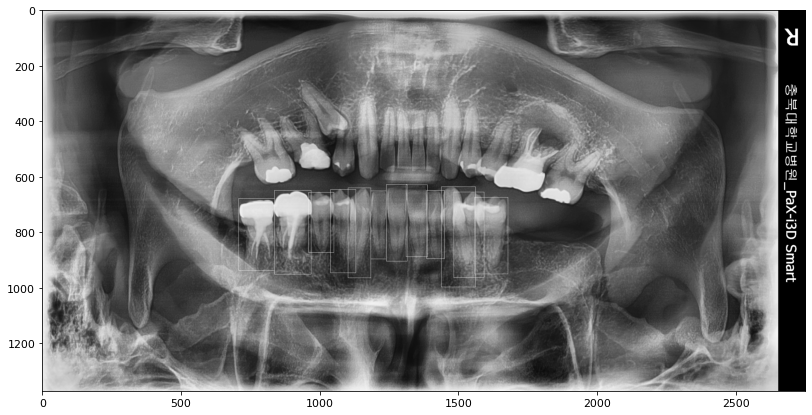

In [273]:
# draw box with yolo annotation
with open('./dataset/yolov5-dataset/labels/train/25_vh_flip.txt') as label:
    img_height, img_width = image.shape[:2]
    lines = [label.rstrip() for label in label.readlines()]
    for line in lines:
        x , y, width, height = [float(item) for item in line.split(' ')[1:]]
#         print(line)
        xc, yc = float(x * img_width) , float(y * img_height)
        box_height, box_width = round(float(img_height) * float(height),5), round(float(img_width) * float(width),5)
        x_min, y_min = int(xc - (box_width / 2)), int(yc - (box_height / 2))
        x_max, y_max = int(xc + (box_width / 2)), int(yc + (box_height / 2))
        cv2.rectangle(copy_image, (x_min, y_min),(x_max, y_max), (255,60,190), 1)
plt.figure(figsize=(20,7))
plt.imshow(copy_image, cmap = 'gray')

In [241]:
image_horizontal_flip = cv2.flip(image, 1)

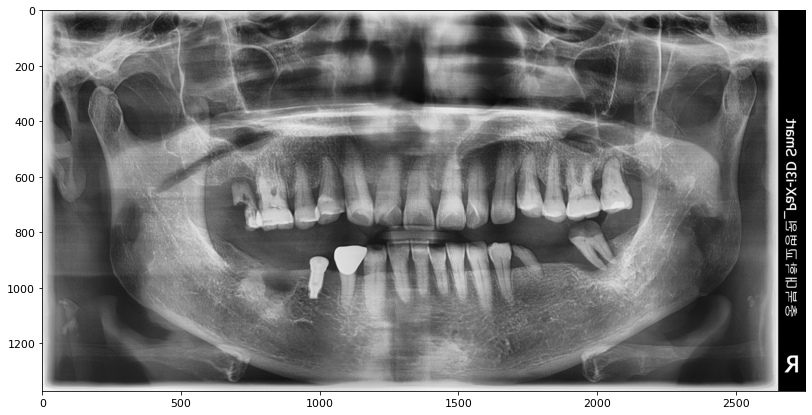

In [185]:
plt.figure(figsize=(20,7))
plt.imshow(image_horizontal_flip, cmap = 'gray')

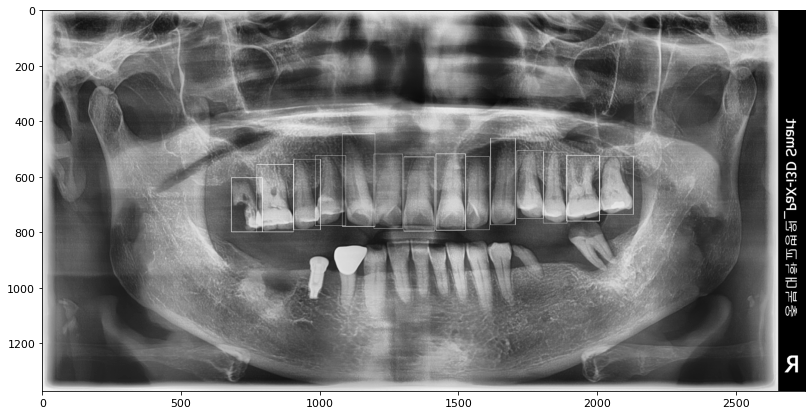

In [218]:
with open('./dataset/yolov5-dataset/labels/train/1.txt') as yolo_annotation:
    label, param1, param2, param3, param4 = [], [], [], [], []
    img_height, img_width = image.shape[:2]
    lines = [yolo_param.rstrip() for yolo_param in yolo_annotation.readlines()]
    for line in lines:
        label_number, param_value = line.split(' ')[0], line.split(' ')[1:]
        x , y, width, height = [float(item) for item in param_value]
        original_xc, original_yc = float(x * img_width) , float(y * img_height)
        box_height, box_width = int(float(img_height) * float(height)), int(float(img_width) * float(width))
        x_min, y_min = int(original_xc - (box_width / 2)), int(original_yc - (box_height / 2))
        x_max, y_max = int(original_xc + (box_width / 2)), int(original_yc + (box_height / 2))
        x_min_flip , y_min_flip = img_width - x_min - box_width, y_min
        x_max_flip , y_max_clip = img_width - x_min, y_max
        xc_flip, yc_flip = int((x_min_flip+x_max_flip)/2), int((y_min_flip+y_max_clip)/2)
#         cv2.rectangle(image_horizontal_flip, (xc_flip-20, yc_flip-20),(xc_flip+20, yc_flip+20), (255,60,190), 1)
        cv2.rectangle(image_horizontal_flip, (x_min_flip, y_min_flip),(x_max_flip , y_max_clip), (255,60,190), 1)
        label.append(label_number)
        param1.append(xc_flip/img_width)
        param2.append(yc_flip/img_height)
        param3.append(box_width/img_width)
        param4.append(box_height/img_height)
    df = pd.DataFrame({'label': label, 'param1': param1, 'param2': param2, 'param3': param3, 'param4': param4})
    df.to_csv(os.path.join('a.txt'), index=False, header=False, sep=' ')

plt.figure(figsize=(20,7))
plt.imshow(image_horizontal_flip, cmap = 'gray')

In [171]:
df

,label,param1,param2,param3,param4
0,6,0.751817,0.459913,0.043968,0.153061
1,5,0.708212,0.467201,0.042878,0.172741
2,4,0.671512,0.465743,0.031250,0.186589
3,3,0.638808,0.457726,0.034884,0.177843
4,2,0.603198,0.449708,0.032340,0.227405
5,1,0.569767,0.480321,0.031250,0.192420
6,0,0.534884,0.477405,0.038881,0.200437
7,7,0.493459,0.482507,0.039971,0.194606
8,8,0.453125,0.475219,0.037791,0.195335
9,9,0.414244,0.446064,0.042878,0.242711


In [ ]:
###### draw box with yolo annotation
with open('./a.txt') as label:
    img_height, img_width = image.shape[:2]
    lines = [label.rstrip() for label in label.readlines()]
    for line in lines:
        x , y, width, height = [float(item) for item in line.split(' ')[1:]]
        print(line)
        xc, yc = float(x * img_width) , float(y * img_height)
        box_height, box_width = round(float(img_height) * float(height),5), round(float(img_width) * float(width),5)
        x_min, y_min = int(xc - (box_width / 2)), int(yc - (box_height / 2))
        x_max, y_max = int(xc + (box_width / 2)), int(yc + (box_height / 2))
        cv2.rectangle(image_horizontal_flip, (x_min, y_min),(x_max, y_max), (255,60,190), 1)
plt.figure(figsize=(20,7))
plt.imshow(image_horizontal_flip, cmap = 'gray')

In [257]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from PIL import Image
import glob

YOLO_TRAIN_DATASET = './dataset/yolov5-dataset/images/train'
YOLO_VALIDATE_DATASET = './dataset/yolov5-dataset/images/val'

YOLO_TRAIN_ANNOTATION = './dataset/yolov5-dataset/labels/train'
YOLO_VALIDATE_ANNOTATION  = './dataset/yolov5-dataset/labels/val'

for teeth in natsorted(os.listdir(YOLO_TRAIN_DATASET)):
    filename, extension = teeth.split('.')
    if teeth.endswith(".png") and 'flip' not in teeth:
        image = Image.open(os.path.join(YOLO_TRAIN_DATASET, teeth))
        image = np.asarray(image)
        image_horizontal_clip = cv2.flip(image, 1)
        image_vertical_clip = cv2.flip(image, 0)
        image_horizontal_vertical_clip = cv2.flip(image, -1)
        Image.fromarray(image_horizontal_clip).save(os.path.join(YOLO_TRAIN_DATASET,f'{filename}_h_flip.{extension}'))
        Image.fromarray(image_vertical_clip).save(os.path.join(YOLO_TRAIN_DATASET,f'{filename}_v_flip.{extension}'))
        Image.fromarray(image_horizontal_vertical_clip).save(os.path.join(YOLO_TRAIN_DATASET,f'{filename}_vh_flip.{extension}'))

1 png
2 png
3 png
4 png
5 png
6 png
7 png
8 png
9 png
10 png
11 png
12 png
13 png
14 png
15 png
17 png
18 png
19 png
20 png
21 png
22 png
23 png
25 png
26 png
27 png
28 png
29 png
30 png
31 png
32 png
33 png
34 png
35 png
39 png
40 png
41 png
43 png
44 png
45 png
47 png
48 png
51 png
52 png
53 png
54 png
55 png
56 png
57 png
58 png
59 png
60 png
61 png
62 png
63 png
64 png
65 png
66 png
67 png
68 png
69 png
70 png
71 png
72 png
73 png
74 png
75 png


In [260]:
# draw box 
for label in natsorted(os.listdir(YOLO_TRAIN_ANNOTATION)):
    filename, extension = label.split('.')
    if label.endswith(".txt") and 'flip' not in label:
        with open(os.path.join(YOLO_TRAIN_ANNOTATION, label)) as yolo_annotation:
            labels, param1, param2, param3, param4 = [], [], [], [], []
            img_height, img_width = image.shape[:2]
            lines = [yolo_param.rstrip() for yolo_param in yolo_annotation.readlines()]
#             print(lines)
            for line in lines:
                label_number, param_value = line.split(' ')[0], line.split(' ')[1:]
                x , y, width, height = [float(item) for item in param_value]
                original_xc, original_yc = float(x * img_width) , float(y * img_height)
                box_height, box_width = int(float(img_height) * float(height)), int(float(img_width) * float(width))
                x_min, y_min = int(original_xc - (box_width / 2)), int(original_yc - (box_height / 2))
                x_max, y_max = int(original_xc + (box_width / 2)), int(original_yc + (box_height / 2))
                x_min_flip , y_min_flip = img_width - x_min - box_width, y_min
                x_max_flip , y_max_clip = img_width - x_min, y_max
                xc_flip, yc_flip = int((x_min_flip+x_max_flip)/2), int((y_min_flip+y_max_clip)/2)
#                 print(label_number, xc_flip/img_width, yc_flip/img_height, box_width/img_width, box_height/img_height)
        #         cv2.rectangle(image_horizontal_flip, (xc_flip-20, yc_flip-20),(xc_flip+20, yc_flip+20), (255,60,190), 1)
#                 cv2.rectangle(image_horizontal_flip, (x_min_flip, y_min_flip),(x_max_flip , y_max_clip), (255,60,190), 1)
                labels.append(label_number)
                param1.append(xc_flip/img_width)
                param2.append(yc_flip/img_height)
                param3.append(box_width/img_width)
                param4.append(box_height/img_height)
            df = pd.DataFrame({'label': labels, 'param1': param1, 'param2': param2, 'param3': param3, 'param4': param4})
            df.to_csv(os.path.join(YOLO_TRAIN_ANNOTATION, f'{filename}_h_flip.{extension}'), index=False, header=False, sep=' ')
            
        with open(os.path.join(YOLO_TRAIN_ANNOTATION, label)) as yolo_annotation:
            labels, param1, param2, param3, param4 = [], [], [], [], []
            img_height, img_width = image.shape[:2]
            lines = [yolo_param.rstrip() for yolo_param in yolo_annotation.readlines()]
#             print(line)
            for line in lines:
                label_number, param_value = line.split(' ')[0], line.split(' ')[1:]
                x , y, width, height = [float(item) for item in param_value]
                original_xc, original_yc = float(x * img_width) , float(y * img_height)
                box_height, box_width = int(float(img_height) * float(height)), int(float(img_width) * float(width))
                x_min, y_min = int(original_xc - (box_width / 2)), int(original_yc - (box_height / 2))
                x_max, y_max = int(original_xc + (box_width / 2)), int(original_yc + (box_height / 2))
                x_min_flip , y_min_flip = x_min , img_height - y_min - box_height
                x_max_flip , y_max_flip = x_max, img_height - y_min
                xc_flip, yc_flip = int((x_min_flip+x_max_flip)/2), int((y_min_flip+y_max_flip)/2)
#                 print(label_number, xc_flip/img_width, yc_flip/img_height, box_width/img_width, box_height/img_height)
        #         cv2.rectangle(image_horizontal_flip, (xc_flip-20, yc_flip-20),(xc_flip+20, yc_flip+20), (255,60,190), 1)
#                 cv2.rectangle(image_horizontal_flip, (x_min_flip, y_min_flip),(x_max_flip , y_max_clip), (255,60,190), 1)
                labels.append(label_number)
                param1.append(xc_flip/img_width)
                param2.append(yc_flip/img_height)
                param3.append(box_width/img_width)
                param4.append(box_height/img_height)
            df = pd.DataFrame({'label': labels, 'param1': param1, 'param2': param2, 'param3': param3, 'param4': param4})
            df.to_csv(os.path.join(YOLO_TRAIN_ANNOTATION, f'{filename}_v_flip.{extension}'), index=False, header=False, sep=' ')
            
        with open(os.path.join(YOLO_TRAIN_ANNOTATION, label)) as yolo_annotation:
            labels, param1, param2, param3, param4 = [], [], [], [], []
            img_height, img_width = image.shape[:2]
            lines = [yolo_param.rstrip() for yolo_param in yolo_annotation.readlines()]
#             print(line)
            for line in lines:
                label_number, param_value = line.split(' ')[0], line.split(' ')[1:]
                x , y, width, height = [float(item) for item in param_value]
                original_xc, original_yc = float(x * img_width) , float(y * img_height)
                box_height, box_width = int(float(img_height) * float(height)), int(float(img_width) * float(width))
                x_min, y_min = int(original_xc - (box_width / 2)), int(original_yc - (box_height / 2))
                x_max, y_max = int(original_xc + (box_width / 2)), int(original_yc + (box_height / 2))
                x_min_flip , y_min_flip = img_width - x_min - box_width , img_height - y_min - box_height
                x_max_flip , y_max_flip = img_width - x_min, img_height - y_min
                xc_flip, yc_flip = int((x_min_flip+x_max_flip)/2), int((y_min_flip+y_max_flip)/2)
#                 print(label_number, xc_flip/img_width, yc_flip/img_height, box_width/img_width, box_height/img_height)
        #         cv2.rectangle(image_horizontal_flip, (xc_flip-20, yc_flip-20),(xc_flip+20, yc_flip+20), (255,60,190), 1)
#                 cv2.rectangle(image_horizontal_flip, (x_min_flip, y_min_flip),(x_max_flip , y_max_clip), (255,60,190), 1)
                labels.append(label_number)
                param1.append(xc_flip/img_width)
                param2.append(yc_flip/img_height)
                param3.append(box_width/img_width)
                param4.append(box_height/img_height)
            df = pd.DataFrame({'label': labels, 'param1': param1, 'param2': param2, 'param3': param3, 'param4': param4})
            df.to_csv(os.path.join(YOLO_TRAIN_ANNOTATION, f'{filename}_vh_flip.{extension}'), index=False, header=False, sep=' ')

In [197]:
# draw box 
for label in natsorted(os.listdir(YOLO_TRAIN_ANNOTATION))[:1]:
    filename, extension = label.split('.')
    if label.endswith(".txt") and 'flip' not in label:
        with open('./a.txt') as label:
            img_height, img_width = image.shape[:2]
            lines = [label.rstrip() for label in label.readlines()]
            for line in lines:
                x , y, width, height = [float(item) for item in line.split(' ')[1:]]
                print(line)
                xc, yc = float(x * img_width) , float(y * img_height)
                box_height, box_width = round(float(img_height) * float(height),5), round(float(img_width) * float(width),5)
                x_min, y_min = int(xc - (box_width / 2)), int(yc - (box_height / 2))
                x_max, y_max = int(xc + (box_width / 2)), int(yc + (box_height / 2))
                cv2.rectangle(image_horizontal_flip, (x_min, y_min),(x_max, y_max), (255,60,190), 1)
        plt.figure(figsize=(20,7))
        plt.imshow(image_horizontal_flip, cmap = 'gray')

1 txt
